## Differential DNA methylation with Illumina 450K arrays (minfi + limma + DMRcate)

This notebook compares DNA methylation between two groups using Illumina HumanMethylation450 (“450K”) arrays. We use minfi to read IDATs, run QC, and perform Noob normalization; limma for CpG-level differential methylation; DMRcate for region-level DMRs. The example dataset is GEO GSE47915 (benign prostate tissue vs tumor; 8 total samples).


In [1]:
# Paths
data_dir <- "data"
ds_dir <- file.path(data_dir, "geo_gse47915_prostate_450k")
downloader <- file.path(data_dir, "downloaders", "download_geo_gse47915.R")

# Packages (assumes installed)
suppressPackageStartupMessages({
  library(minfi)
  library(limma)
  library(DMRcate)
  library(missMethyl)
  library(GEOquery)
  library(ggplot2)
  library(SummarizedExperiment)
  library(S4Vectors)
})

# Download dataset (creates ds_dir with idats/ + targets.csv)
source(downloader)
download_if_missing(data_dir, gse = "GSE47915")


## 2) Load the IDATs into minfi

targets.csv provides a Basename (a file prefix) per sample pointing to the paired *_Grn.idat / *_Red.idat files.
We load the IDATs into an RGChannelSet, then attach the targets table as phenotype metadata.


In [ ]:
targets <- read.csv(file.path(ds_dir, "targets.csv"), stringsAsFactors = FALSE)
targets[, c("Sample_Name", "geo_accession", "Sample_Group", "Basename")]

rgSet <- read.metharray.exp(
    base = file.path(ds_dir, "idats"),
    targets = targets,
    extended = TRUE  # keeps additional control/probe information for QC and downstream steps
)

# keep stable, human-readable sample names
colnames(rgSet) <- make.unique(targets$Sample_Name)

# store phenotype directly on the object
pheno <- targets
rownames(pheno) <- colnames(rgSet)
colData(rgSet) <- DataFrame(pheno)

rgSet
table(colData(rgSet)$Sample_Group, useNA = "ifany")

Sample_Name,geo_accession,Sample_Group,Basename
<chr>,<chr>,<chr>,<chr>
GSM1162363_6264509108_R01C02,GSM1162363,benign,idats/GSM1162363_6264509108_R01C02
GSM1162364_6264509130_R04C02,GSM1162364,tumor,idats/GSM1162364_6264509130_R04C02
GSM1162365_6264509130_R03C02,GSM1162365,tumor,idats/GSM1162365_6264509130_R03C02
GSM1162369_6264509130_R06C01,GSM1162369,tumor,idats/GSM1162369_6264509130_R06C01
GSM1162375_6264509130_R05C01,GSM1162375,tumor,idats/GSM1162375_6264509130_R05C01
GSM1162380_6285609104_R03C02,GSM1162380,benign,idats/GSM1162380_6285609104_R03C02
GSM1162381_6285650040_R06C02,GSM1162381,benign,idats/GSM1162381_6285650040_R06C02
GSM1162382_6285650050_R01C01,GSM1162382,benign,idats/GSM1162382_6285650050_R01C01


class: RGChannelSetExtended 
dim: 622399 8 
metadata(0):
assays(5): Green Red GreenSD RedSD NBeads
rownames(622399): 10600313 10600322 ... 74810490 74810492
rowData names(0):
colnames(8): GSM1162363_6264509108_R01C02 GSM1162364_6264509130_R04C02
  ... GSM1162381_6285650040_R06C02 GSM1162382_6285650050_R01C01
colData names(5): Sample_Name geo_accession title Sample_Group Basename
Annotation
  array: IlluminaHumanMethylation450k
  annotation: ilmn12.hg19


benign  tumor 
     4      4 

## 3) Quality control

The two most common early checks are:
- **Median intensity QC**: samples with unusually low methylated/unmethylated signal are often poor-quality. Additionally, samples that aren't in the main cluster of points may be outliers. We'll see this with `plotQC`.
- **Detection p-values**: quantify whether a probe’s signal is distinguishable from background in that sample.


Loading required package: IlluminaHumanMethylation450kmanifest



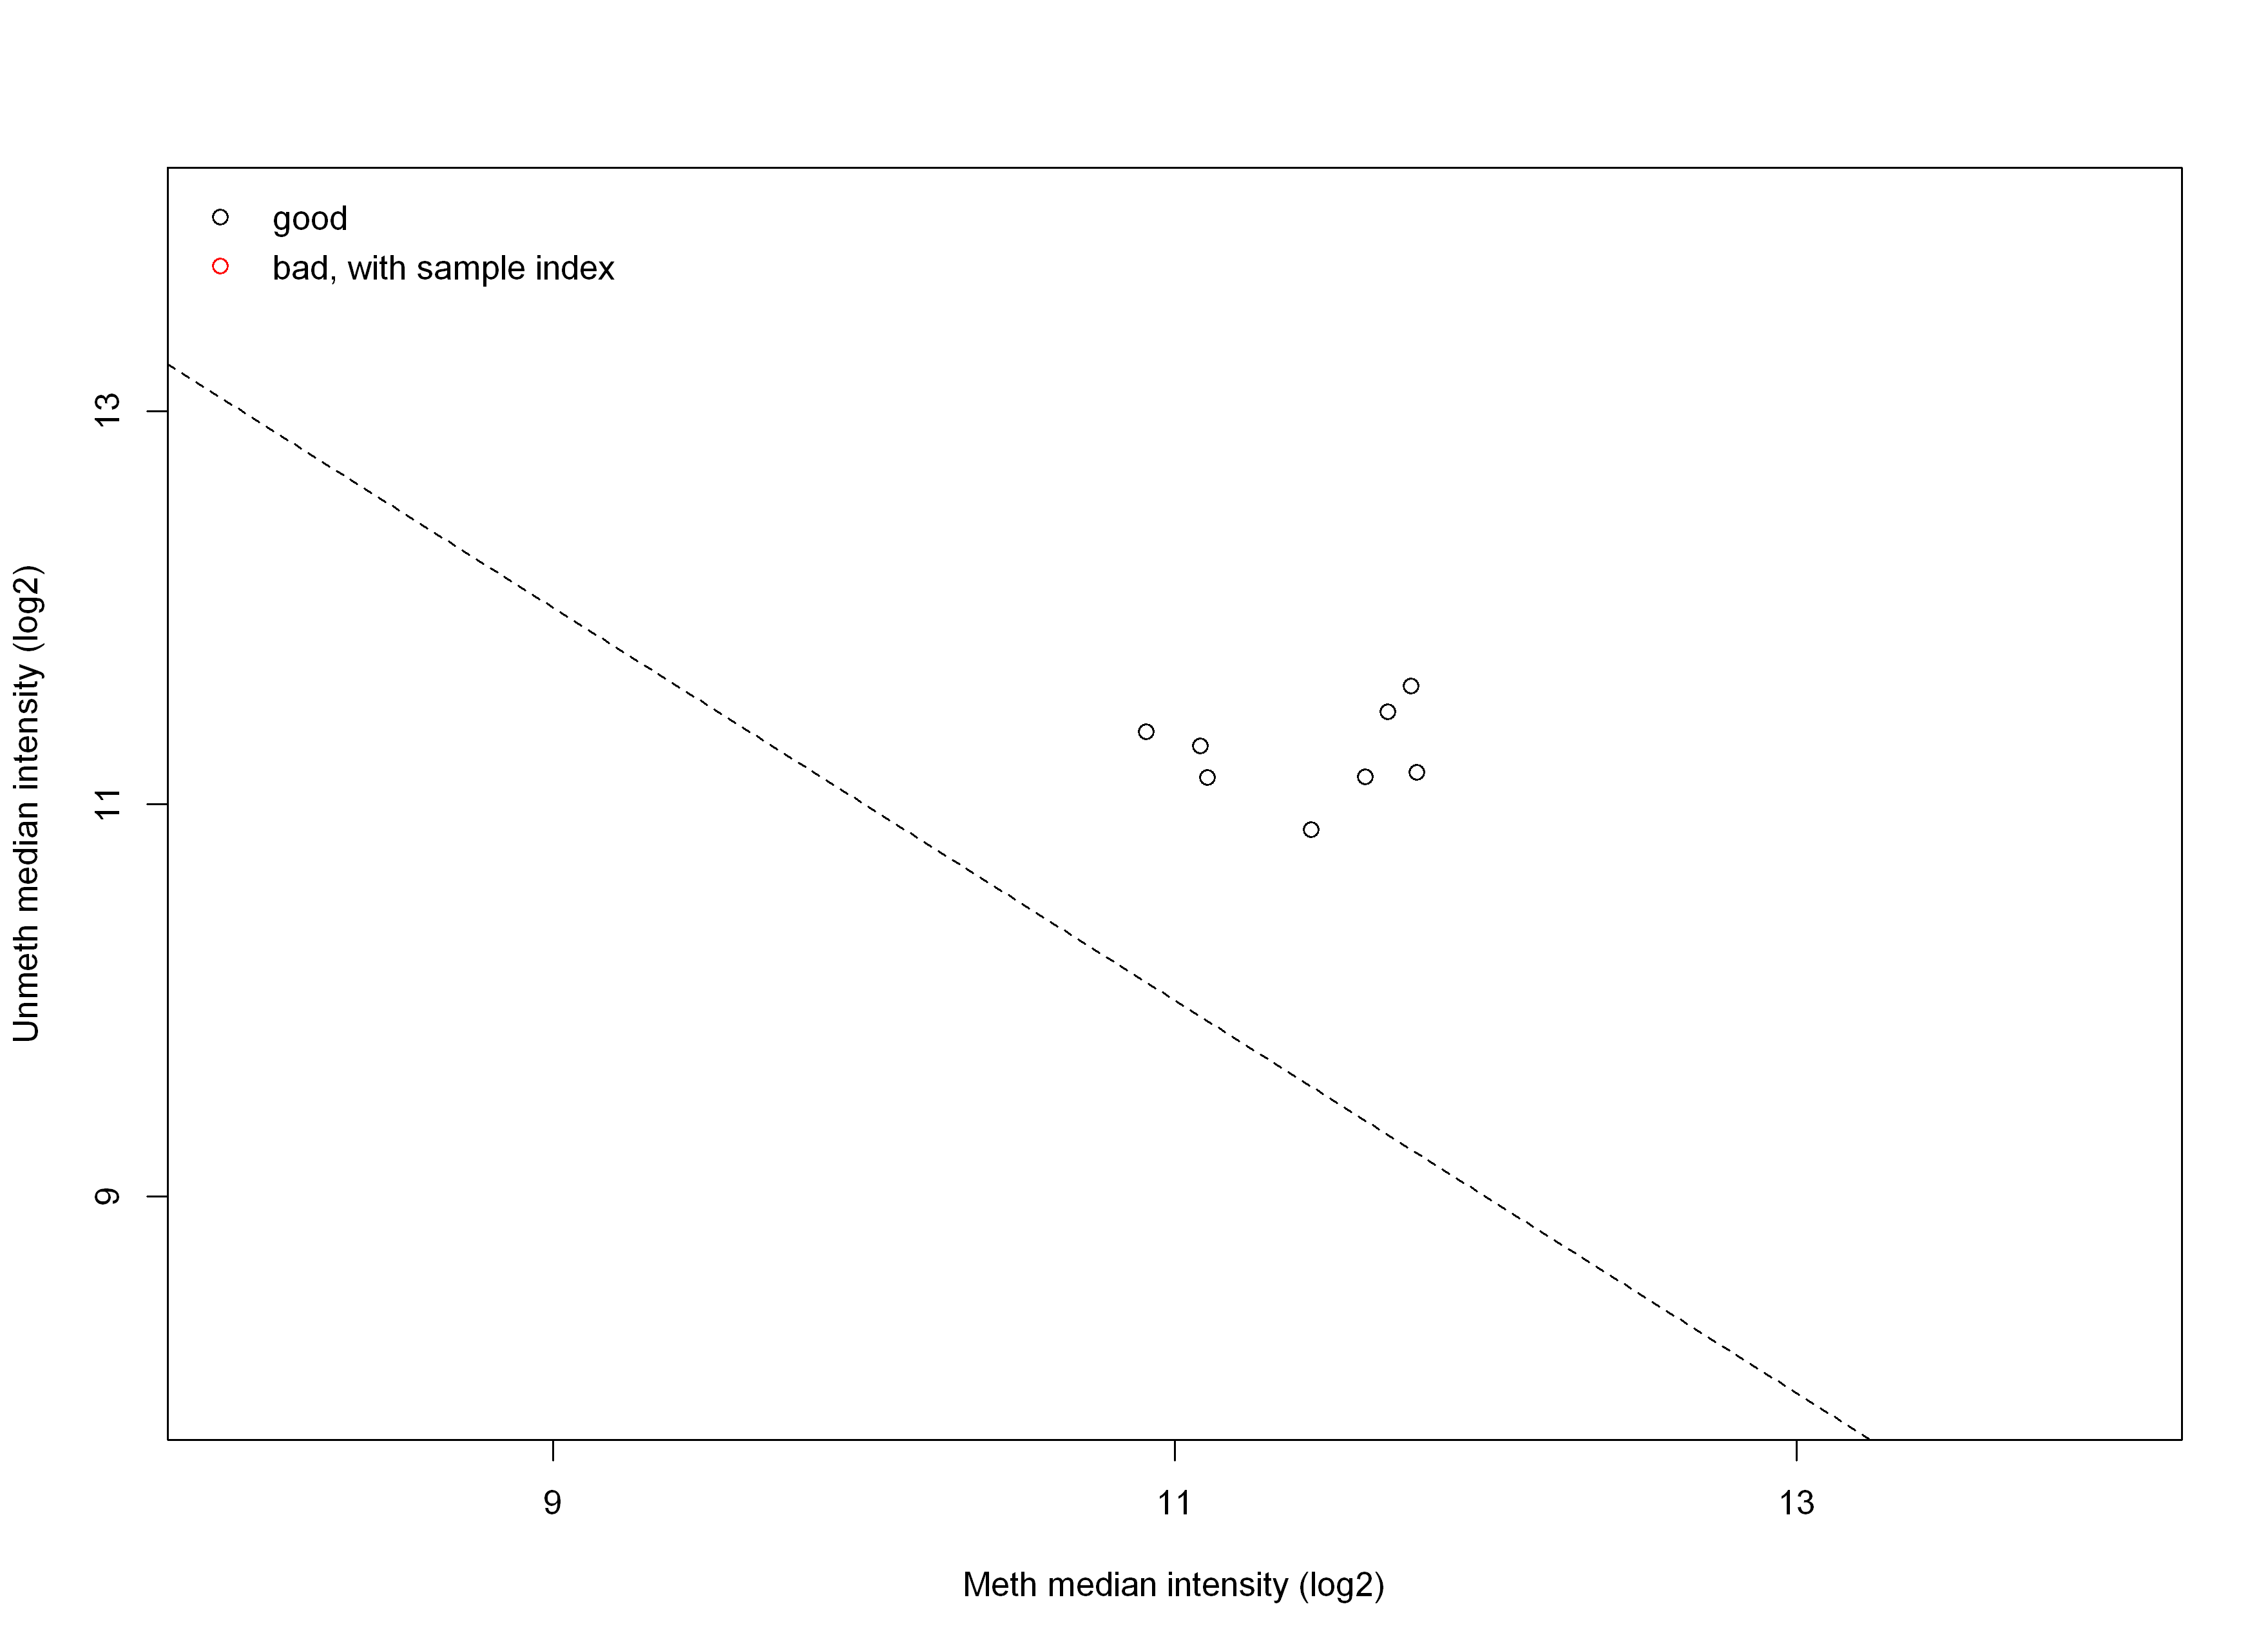

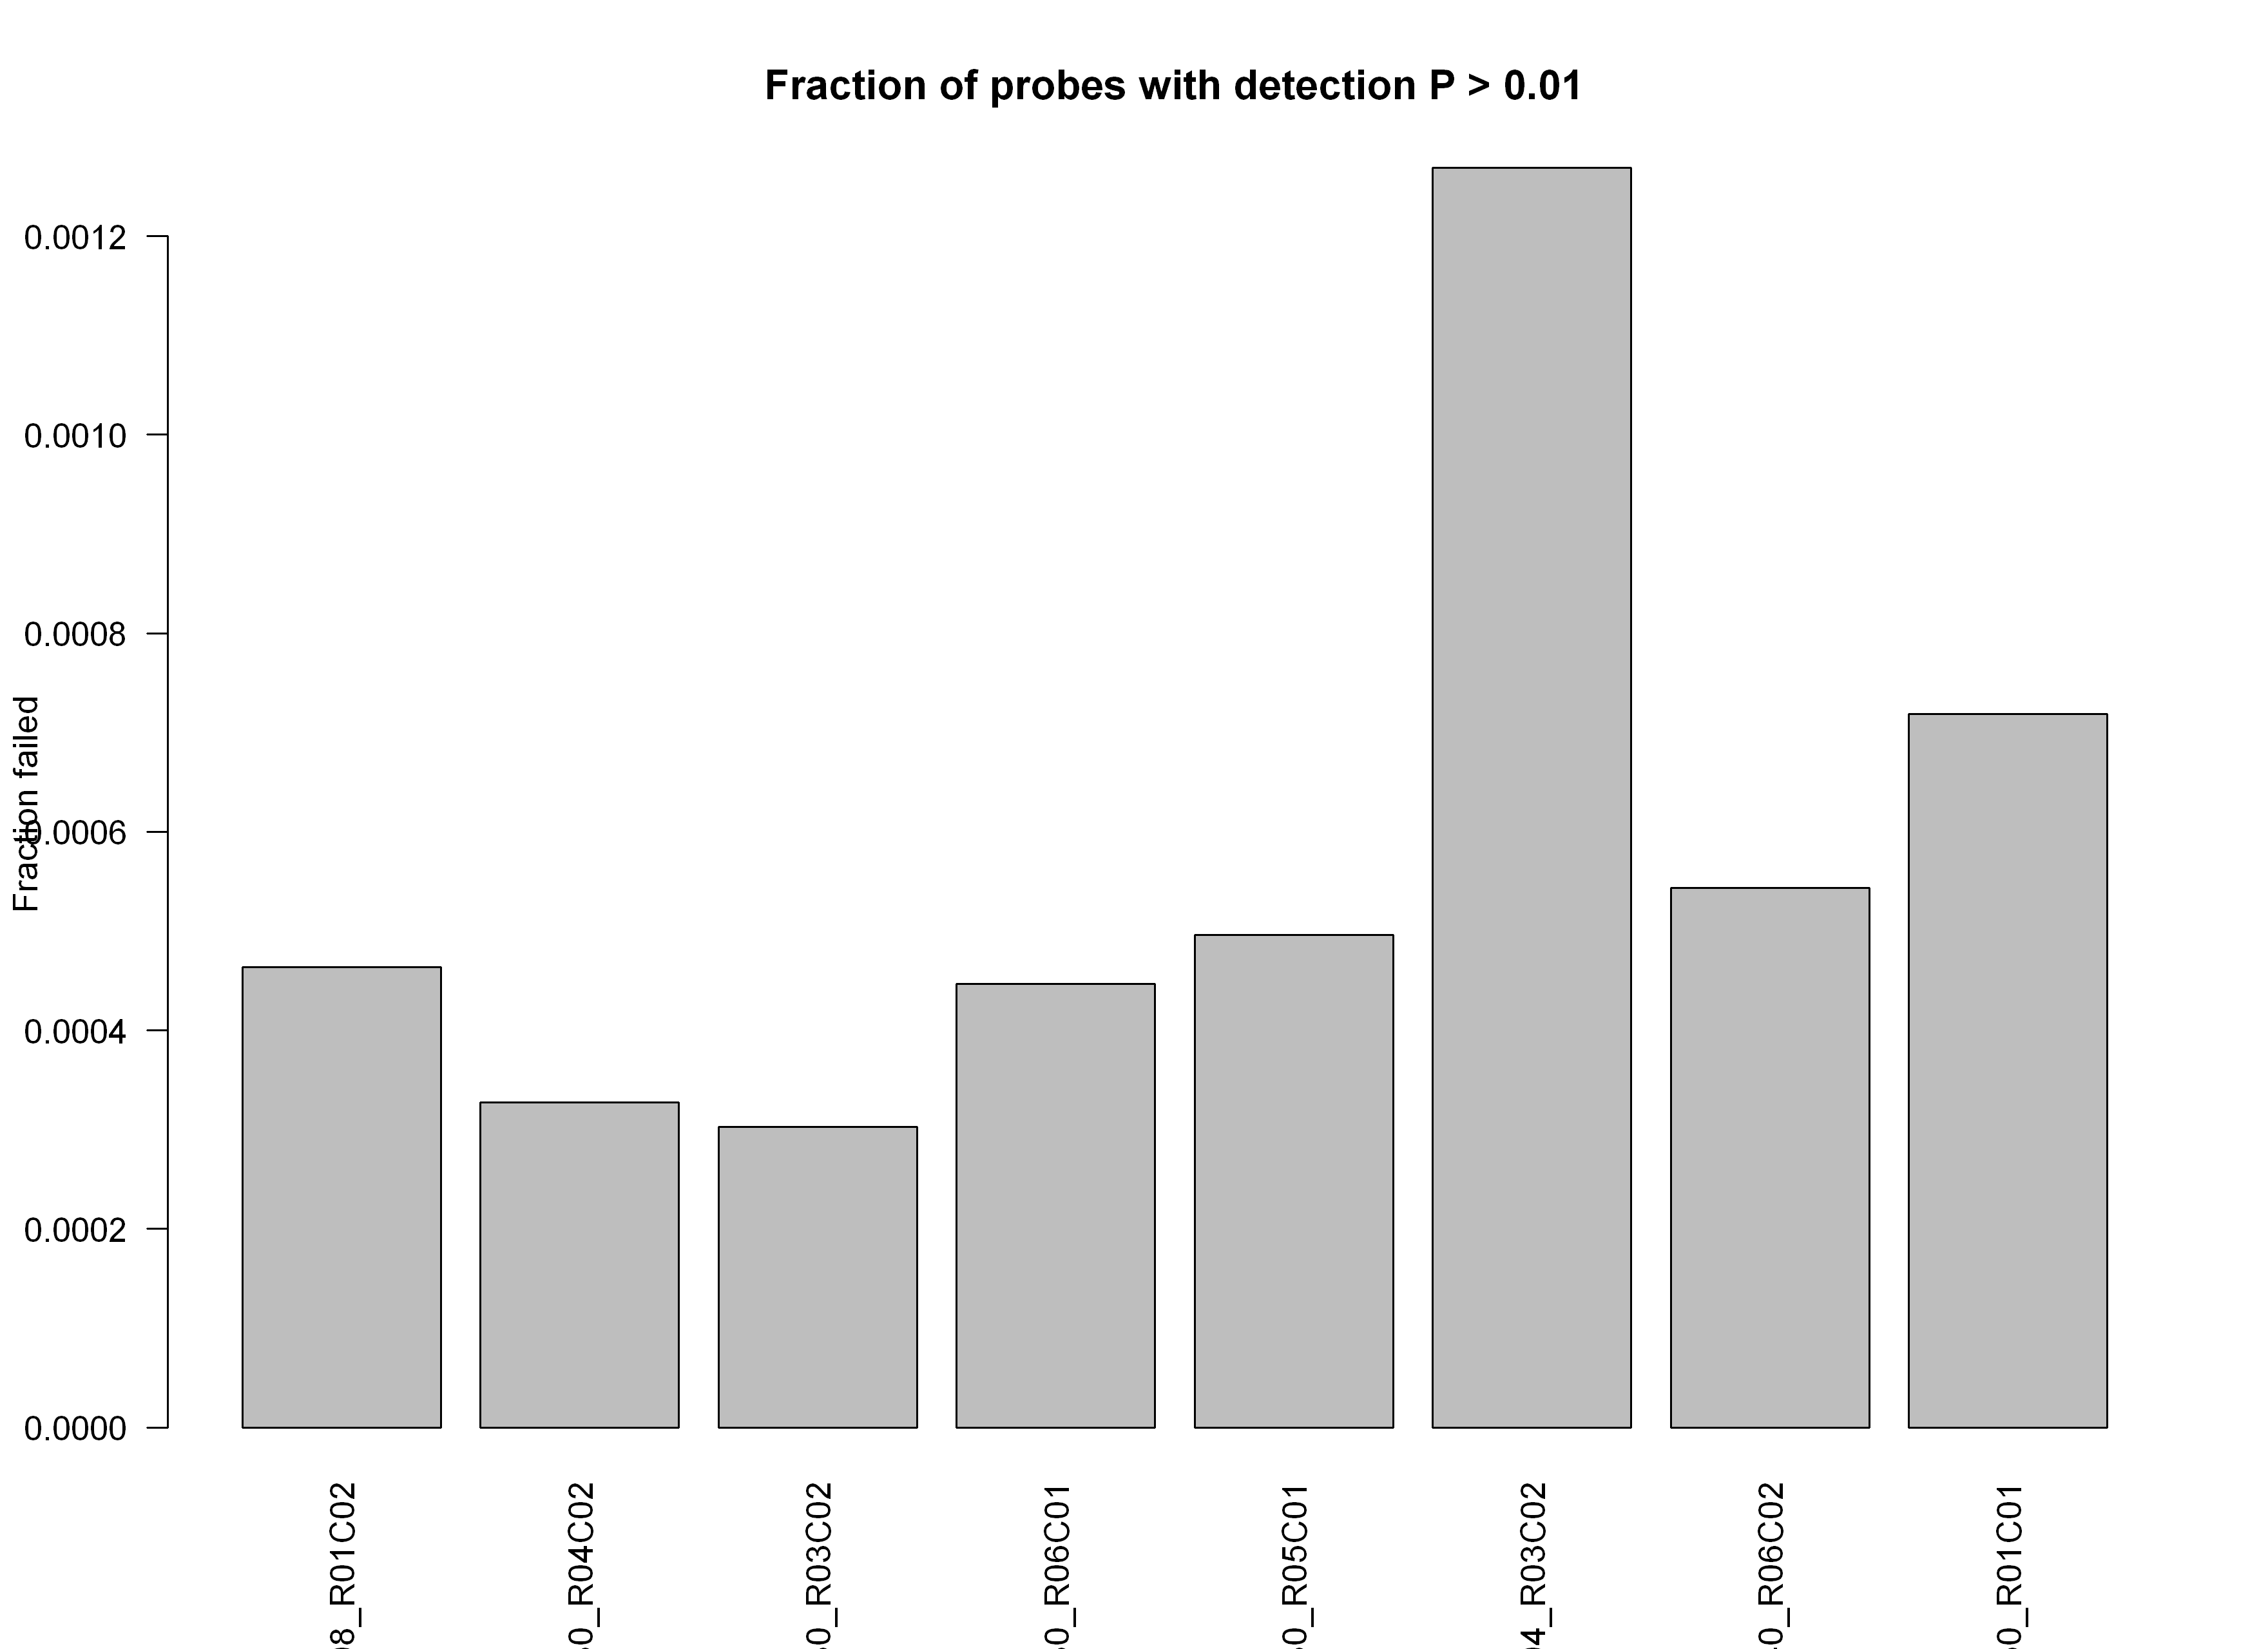

In [ ]:
mSet_raw <- minfi::preprocessRaw(rgSet)
qc <- minfi::getQC(mSet_raw)
minfi::plotQC(qc)


detP <- detectionP(rgSet)

frac_failed <- colMeans(detP > 0.01, na.rm = TRUE)
barplot(frac_failed, las = 2,
        main = "Fraction of probes with detection P > 0.01",
        ylab = "Fraction failed")
abline(h = 0.01, lty = 2)


## 4) Normalization + quick exploration of Beta and M-values
Illumina methylation arrays measure two fluorescence intensities at each CpG probe: the methylated and unmethylated signal intensity.
From these, we compute two common methylation measures:
- Beta values are the estimated fraction methylated at a CpG. Ranges from 0 to 1 (0 = mostly unmethylated, 1 = mostly methylated). Best for plots and effect sizes, e.g. Δβ = mean(β_tumor) − mean(β_benign).
Downside: Beta values have non-constant variance (values near 0/1 behave differently than values near 0.5), which is inconvenient for standard linear models.
- M-values are the log-ratio of methylated to unmethylated signal. Ranges from −∞ to +∞. More symmetric and closer to “normal-like” behavior across the genome, so they’re the default for limma and many other linear-model based tests.

We typically fit models on M-values (better statistics) but report and interpret Δβ (more intuitive biology).

We'll use Noob background correction as a strong default for Illumina arrays (450k, 850k, EPIC) because it corrects background fluorescence using built-in negative control behavior (“out-of-band” signal). This usually improves comparability across samples without being overly aggressive.

Typical quick plots: 
- Beta density: samples should have broadly similar bimodal shapes with peaks near low and high methylation (common in array data). Strong shifts/outliers can indicate technical issues or extreme biology.
- MDS/PCA: MDS places samples close together if their genome-wide methylation profiles are similar. If samples cluster by sample group, that supports a biological signal. If they cluster by technical factors (slide/plate/run date), that suggests batch effects you may need to model.

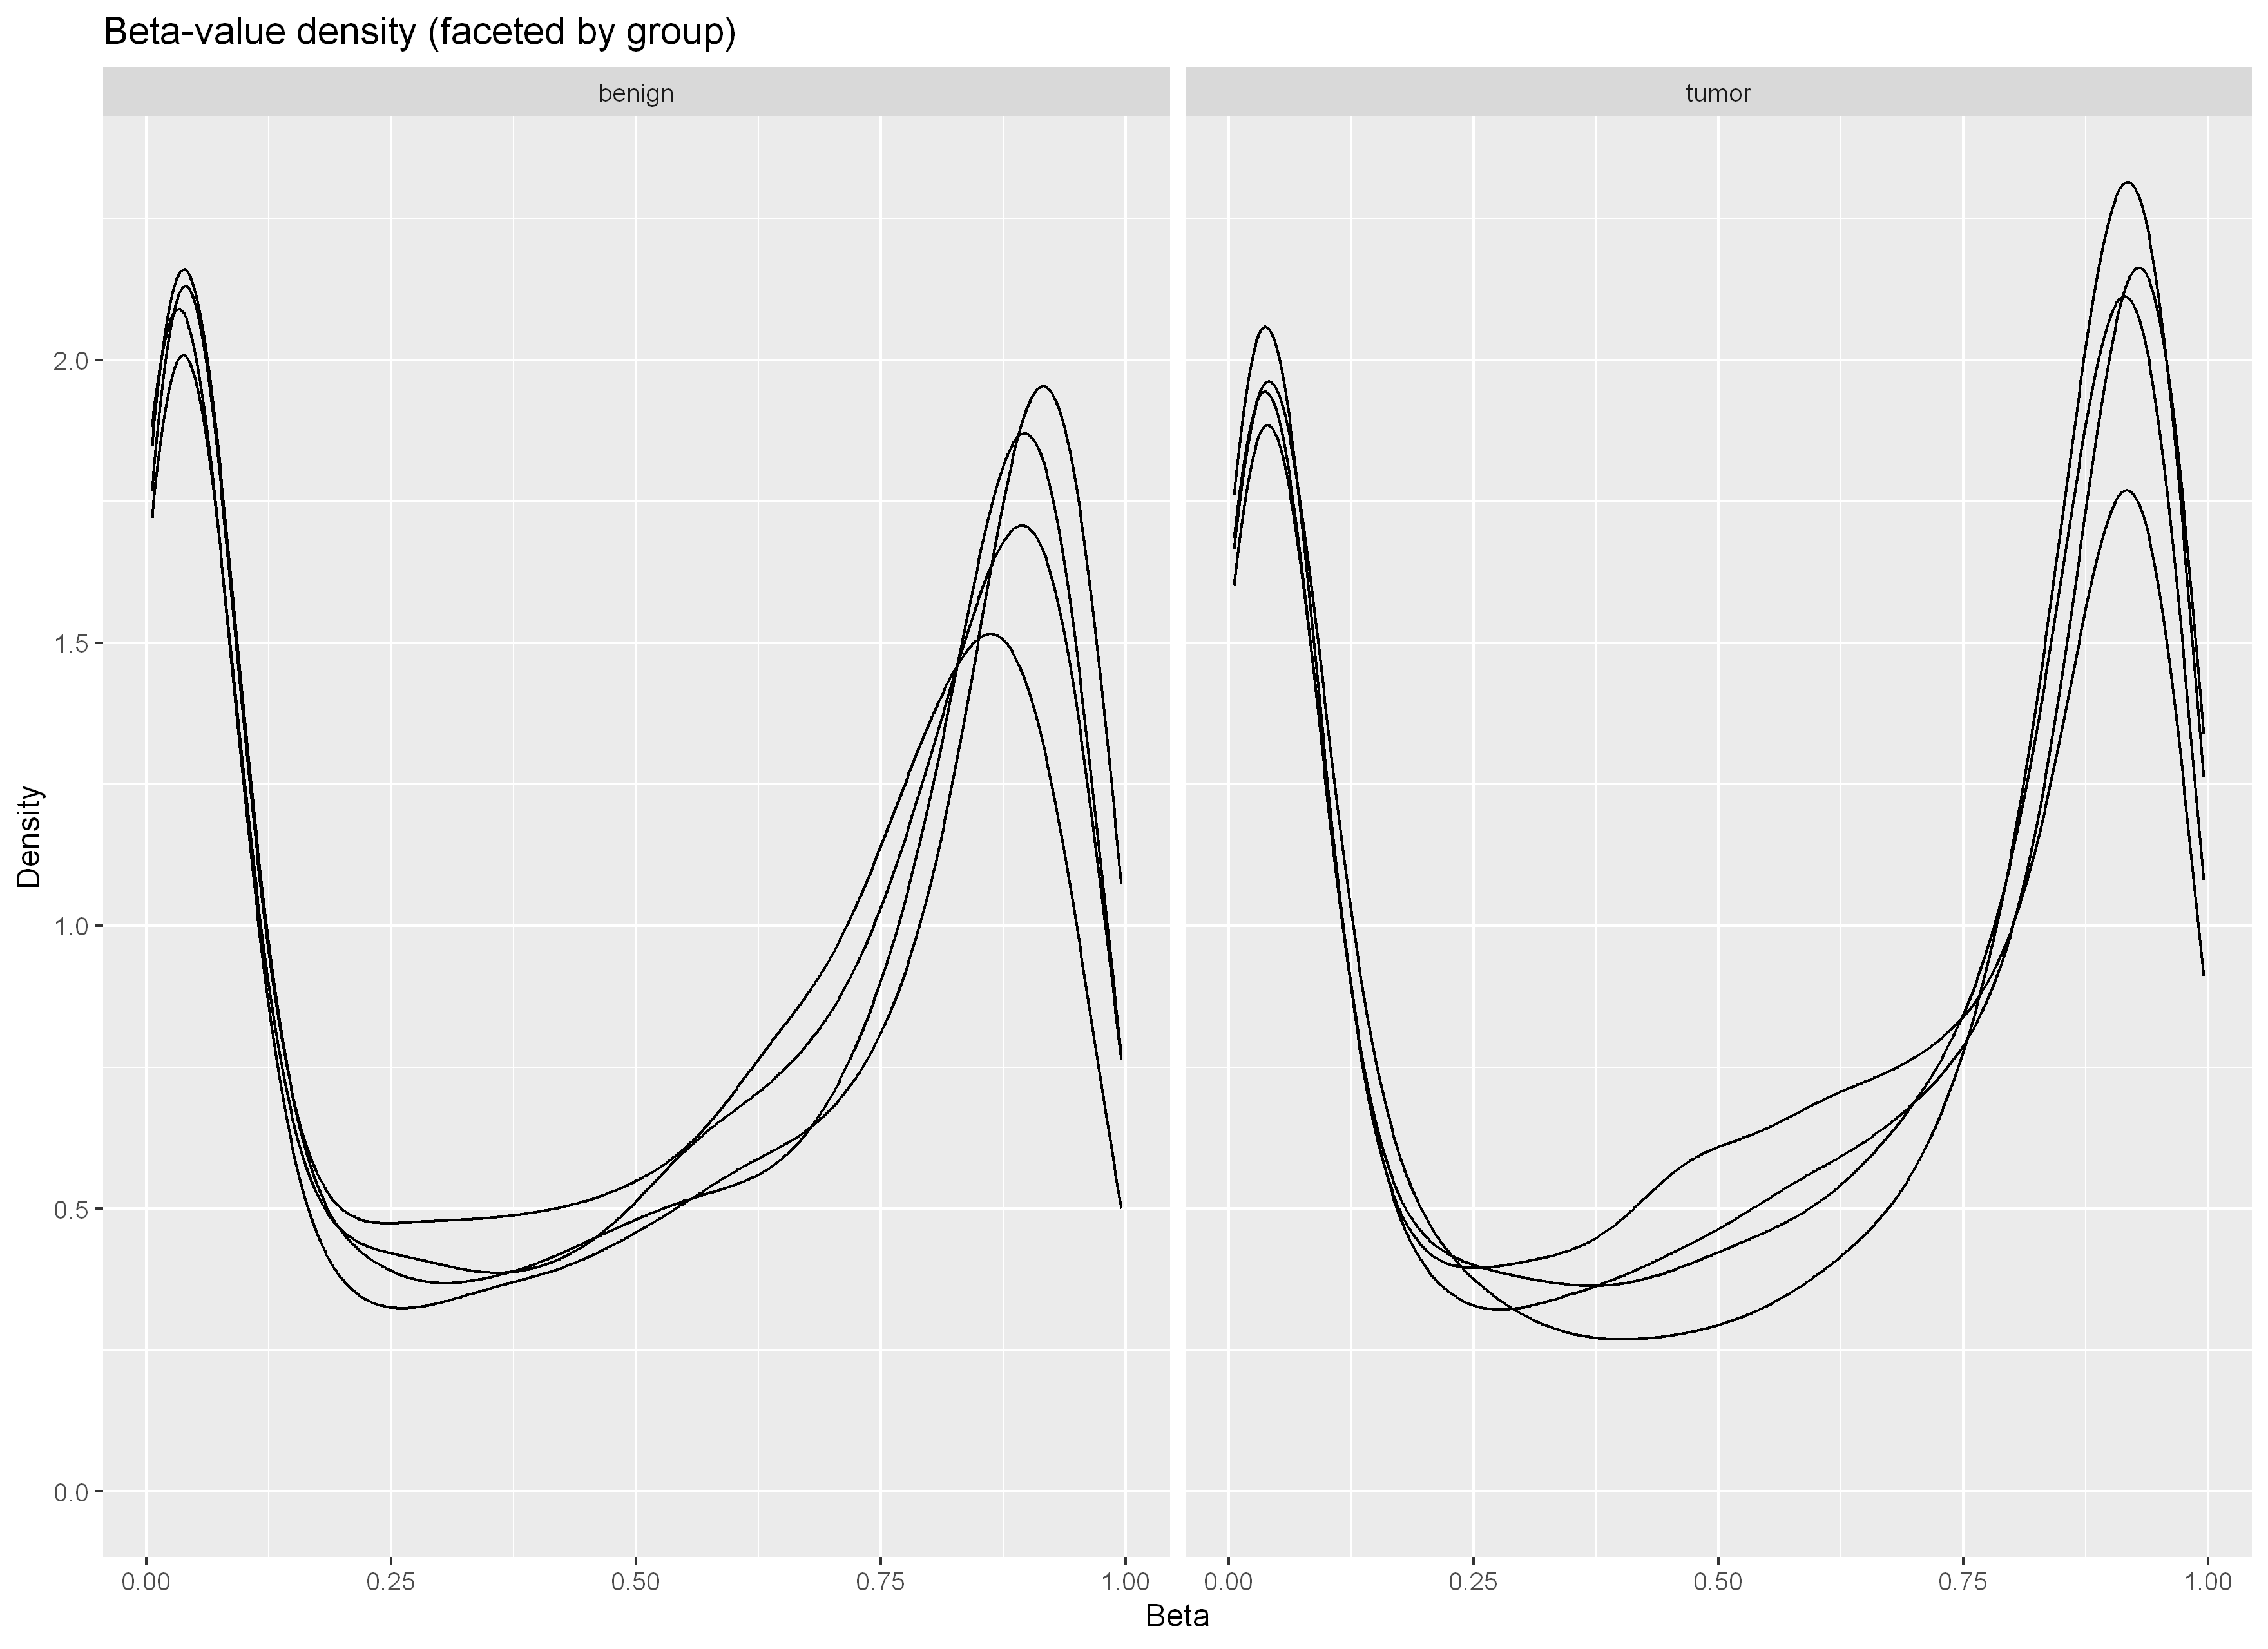

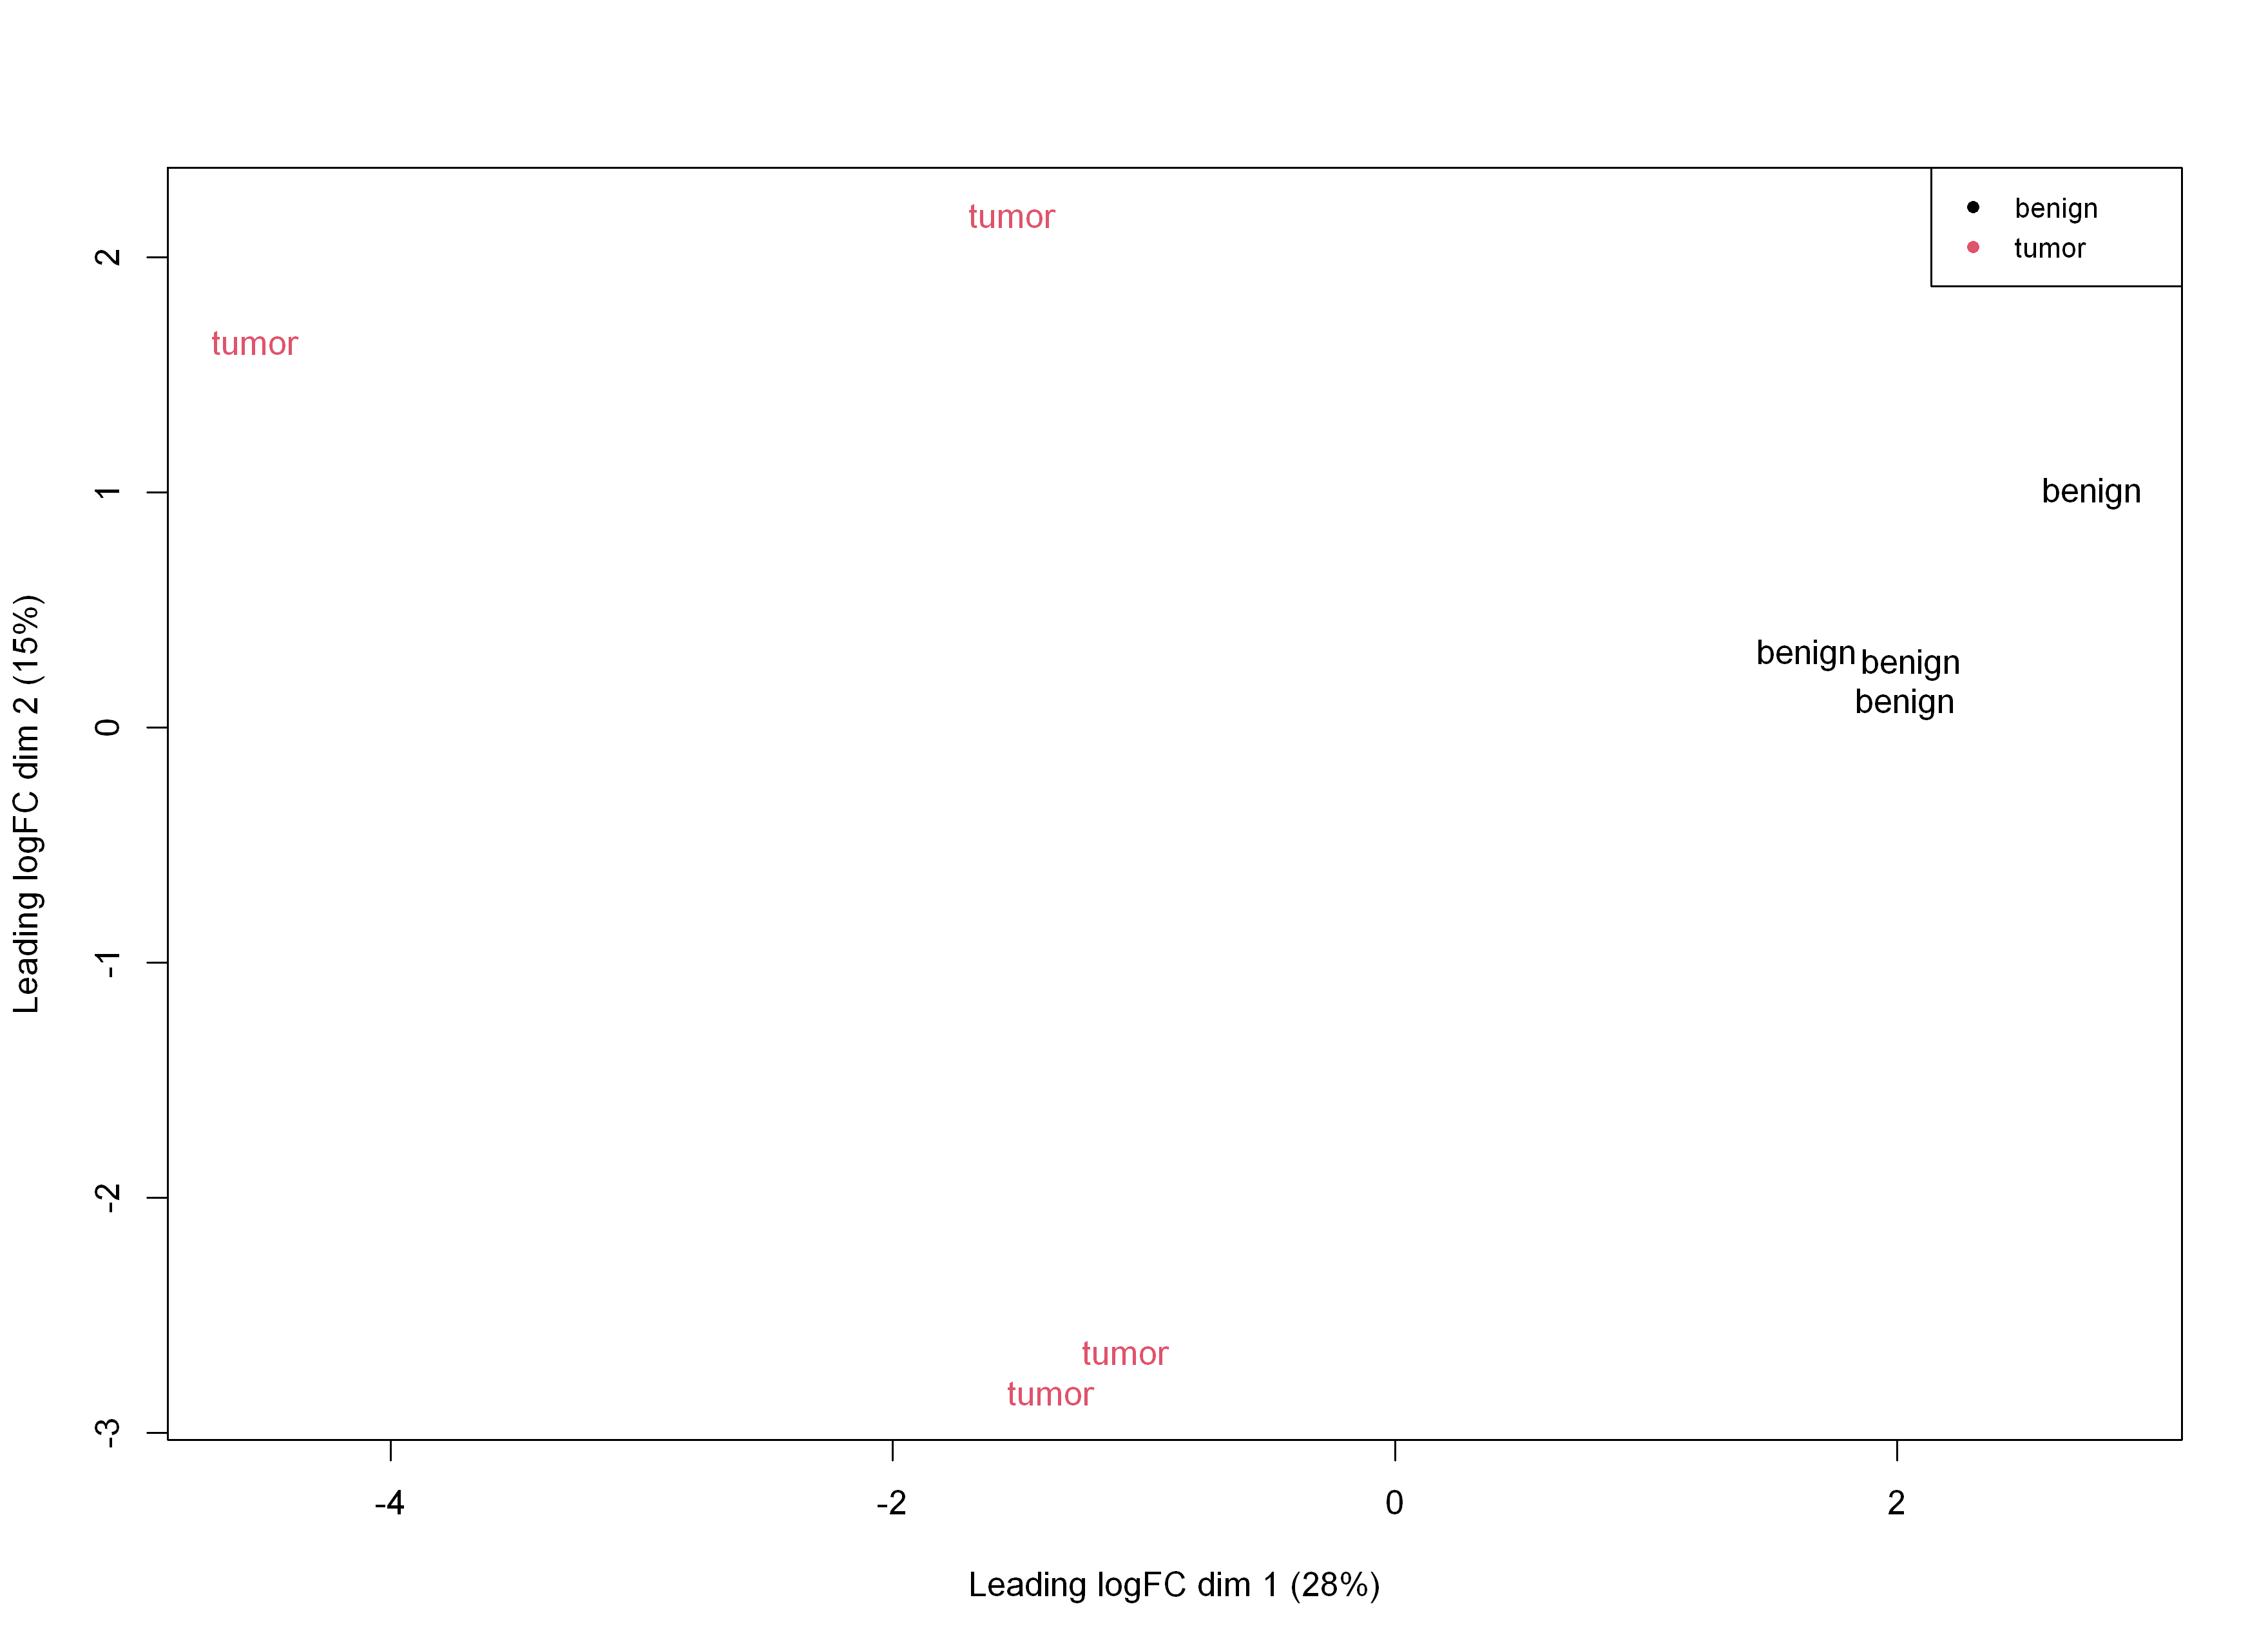

In [ ]:
gSet <- minfi::preprocessNoob(rgSet)   # Noob normalized
beta <- minfi::getBeta(gSet)
mvals <- minfi::getM(gSet)

pheno <- as.data.frame(colData(gSet))
group <- factor(pheno$Sample_Group)

set.seed(1)
idx <- sample(seq_len(nrow(beta)), 10000)

beta_long <- data.frame(
  beta   = as.vector(beta[idx, , drop = FALSE]),
  sample = rep(colnames(beta), each = length(idx)),
  group  = rep(group, each = length(idx))
)

ggplot(beta_long, aes(x = beta, group = sample)) +
  geom_density(alpha = 0.15) +
  facet_wrap(~group, ncol = 2) +
  labs(title = "Beta-value density (faceted by group)", x = "Beta", y = "Density")

plotMDS(mvals, labels = group, col = as.integer(group))
legend("topright", legend = levels(group), col = seq_along(levels(group)), pch = 16, cex = 0.8)

## 5) Filter probes by detection p-value

Keep probes that pass P ≤ 0.01 in ≥ 90% of samples.
This step reduces false positives driven by missing/failed measurements.
The p-value in this context is how strong the probe fluorescence is compared to negative-control probes. P=0.01 means a probe has an intensity like the 99th percentile of negative-control probes in that sample.

One thing to keep in mind is the potential loss of biological relevance. For example, dropped probes may include loci affected by SNPs that are relevant to your research question. If these loci are of interest, follow up with genotype-aware analysis or sequencing.

In [ ]:
keep_probes <- rowMeans(detP <= 0.01, na.rm = TRUE) >= 0.90
sum(keep_probes)

gSet <- gSet[keep_probes, ]
beta <- getBeta(gSet)
mvals <- getM(gSet)

[1] 483894

## 6) Differential methylation at CpG sites (DMPs) with limma

We model M-values and test the tumor vs benign group effect.

A common interpretation step is pairing statistical significance with effect size (e.g., |Δβ| ≥ 0.10).


In [8]:
pheno <- as.data.frame(colData(gSet))
pheno <- pheno[!is.na(pheno$Sample_Group), ]
pheno$Sample_Group <- factor(pheno$Sample_Group, levels = c("benign", "tumor"))

gSet_sub  <- gSet[, rownames(pheno)]
m_sub     <- getM(gSet_sub)
beta_sub  <- getBeta(gSet_sub)

design <- model.matrix(~ Sample_Group, data = pheno)

fit <- eBayes(lmFit(m_sub, design))
dmp <- topTable(fit, coef = "Sample_Grouptumor", number = Inf, sort.by = "P", adjust.method = "BH")

dmp$delta_beta <- rowMeans(beta_sub[, pheno$Sample_Group == "tumor", drop = FALSE]) -
  rowMeans(beta_sub[, pheno$Sample_Group == "benign", drop = FALSE])

table(dmp$adj.P.Val < 0.05)
dmp[, c("logFC", "P.Value", "adj.P.Val", "delta_beta")] |> head()


 FALSE   TRUE 
444120  39774 

,logFC,P.Value,adj.P.Val,delta_beta
,<dbl>,<dbl>,<dbl>,<dbl>
cg20527270,6.173397,3.244420e-10,5.174852e-05,-0.187496972
cg27299406,6.574279,3.555396e-10,5.174852e-05,-0.009983249
cg16794576,6.623313,4.627838e-10,5.174852e-05,-0.234870933
cg23511432,6.389217,5.921648e-10,5.174852e-05,-0.006851208
cg11849086,5.696038,5.925290e-10,5.174852e-05,-0.100779014
cg19670286,5.976985,6.416511e-10,5.174852e-05,0.002295709


### Volcano-style view

You typically look for CpGs with both strong statistical support and meaningful methylation difference (e.g., |Δβ| ≥ 0.10).


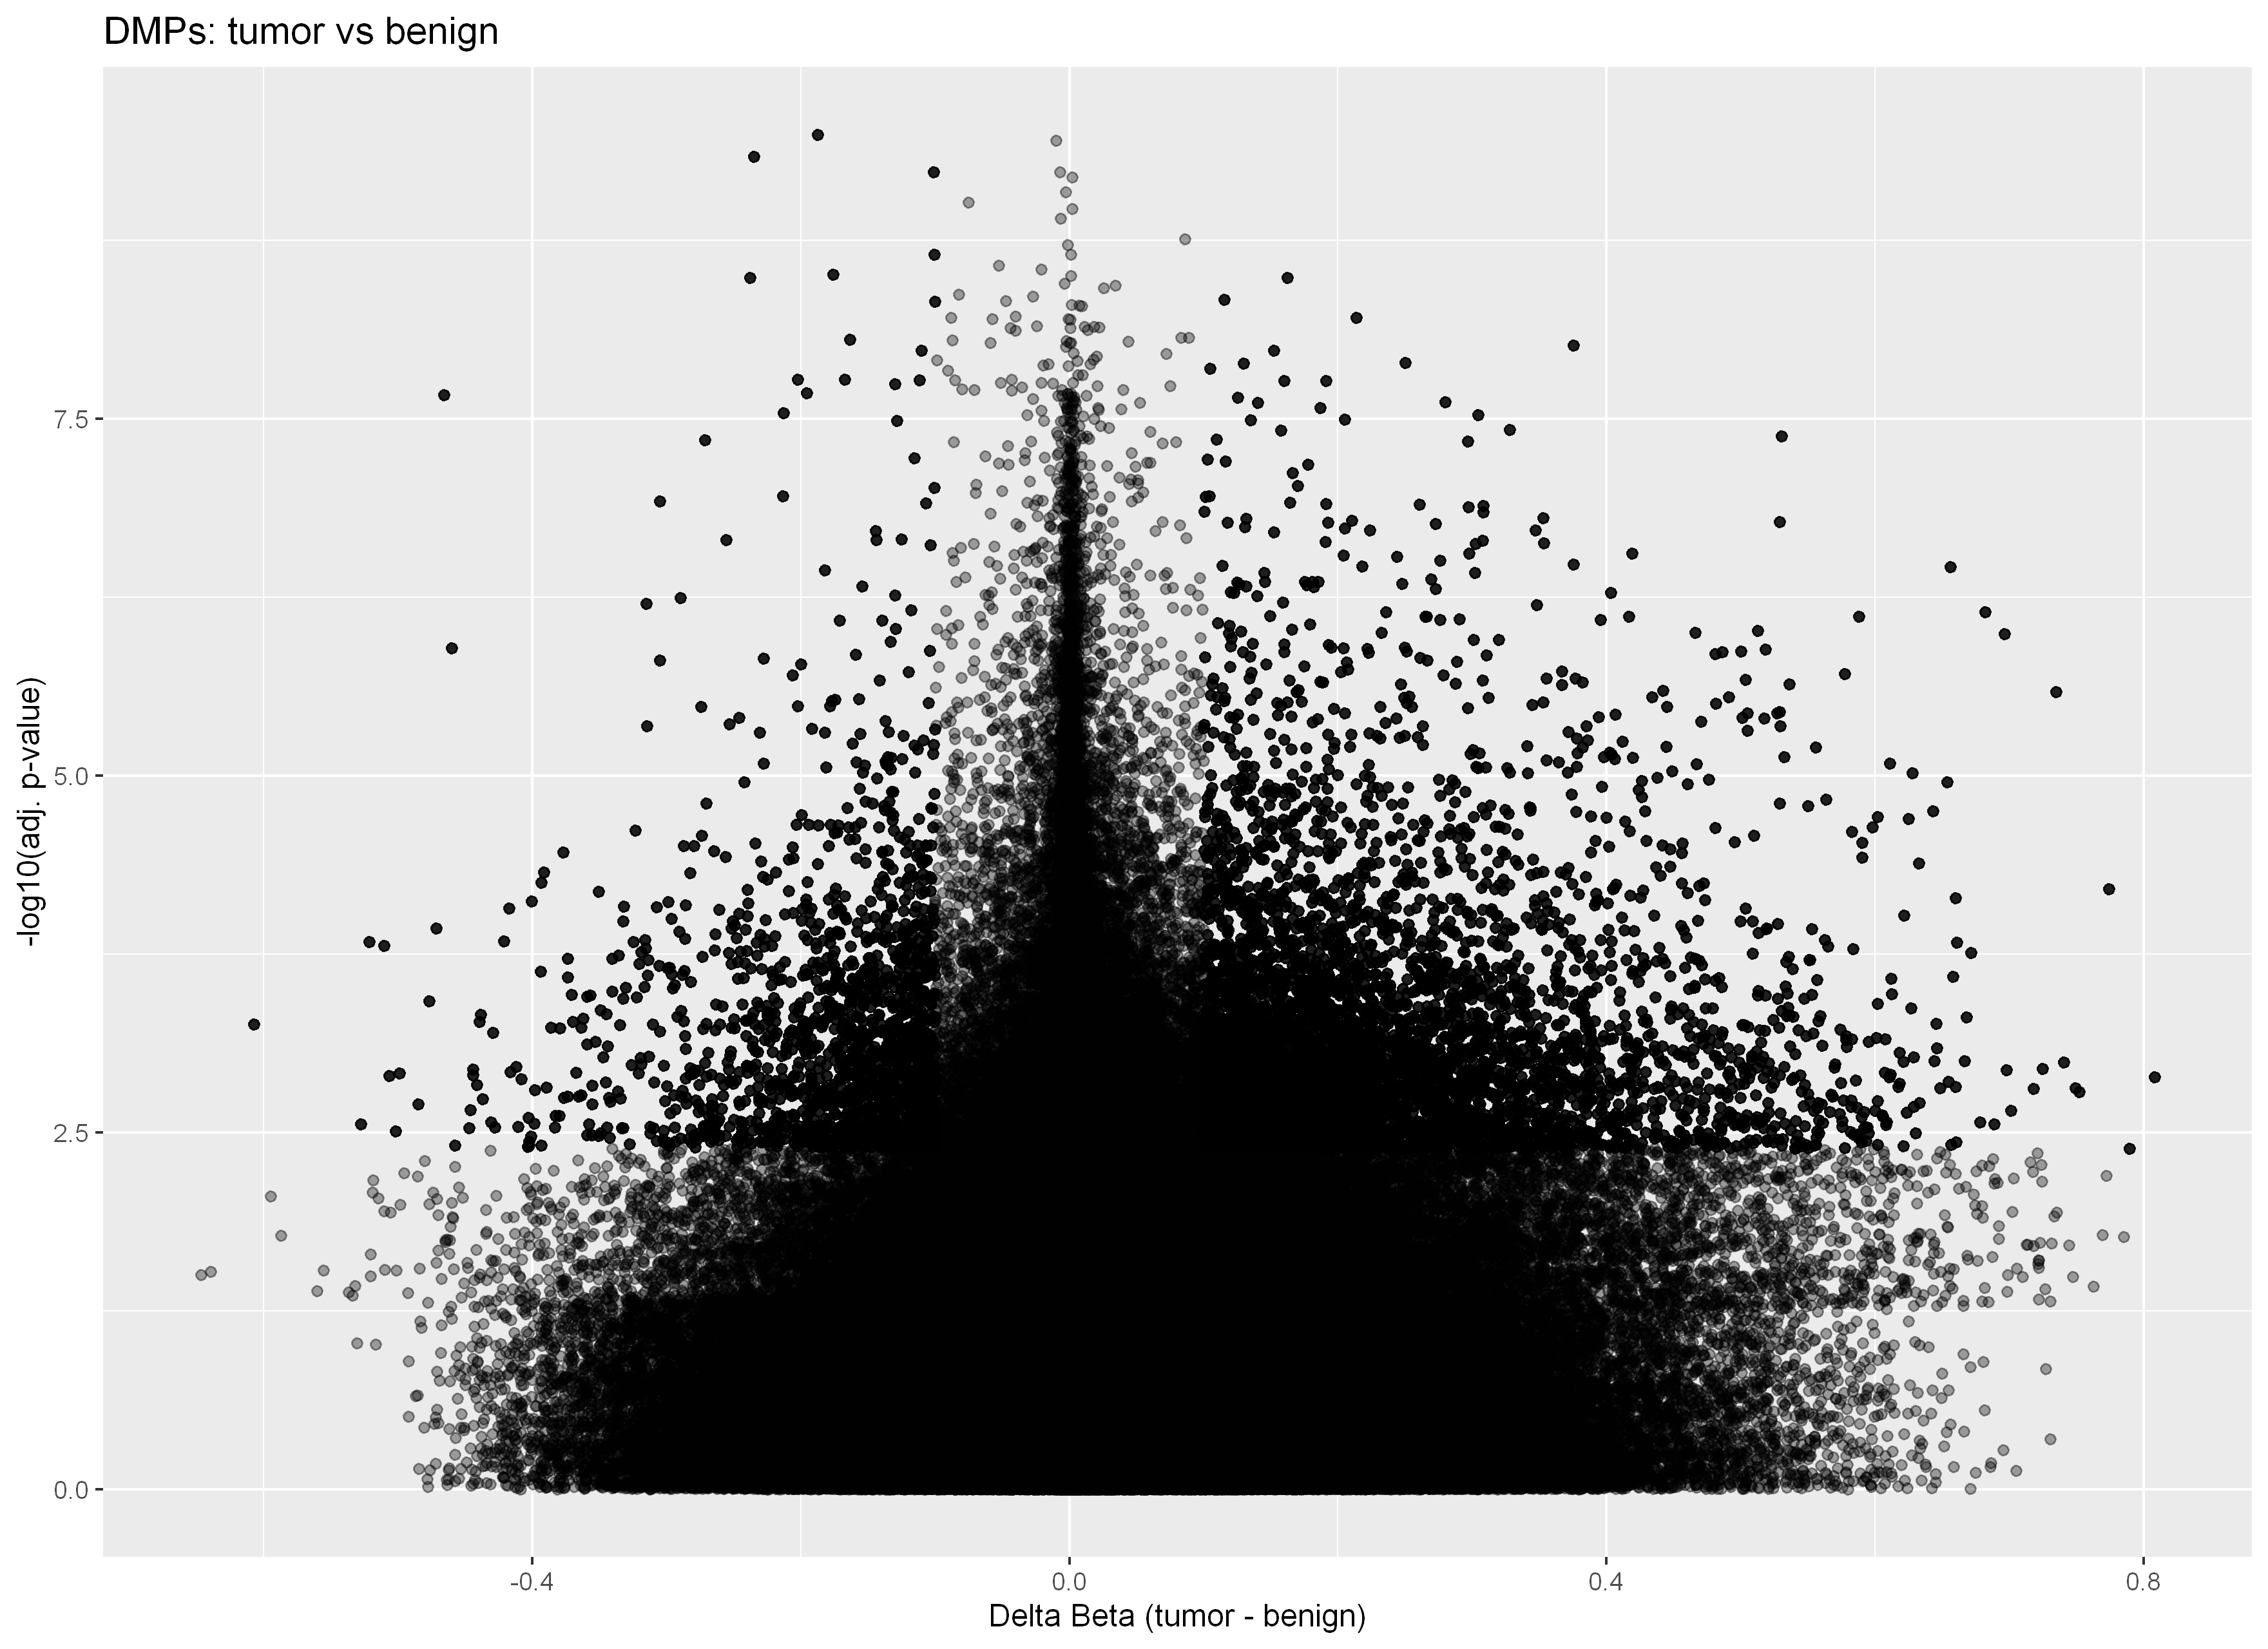

In [10]:
dmp$neglog10p <- -log10(dmp$P.Value)
dmp$hit <- (dmp$adj.P.Val < 0.05) & (abs(dmp$delta_beta) >= 0.10)

ggplot(dmp, aes(x = delta_beta, y = neglog10p)) +
  geom_point(alpha = 0.35) +
  geom_point(data = subset(dmp, hit), alpha = 0.8) +
  labs(
    title = "DMPs: tumor vs benign",
    x = "Delta Beta (tumor - benign)",
    y = "-log10(adj. p-value)"
  )

## 7) Regional differential methylation (DMRs) with DMRcate

DMRs are clusters of nearby CpGs that shift together, which often map more cleanly onto regulatory elements than individual CpGs.


### Visualize the top DMR

`DMR.plot()` shows CpGs in the region, a heatmap of sample beta values, and group means across the region.


Your contrast returned 39774 individually significant probes. We recommend the default setting of pcutoff in dmrcate().

Fitting chr1...

Fitting chr2...

Fitting chr3...

Fitting chr4...

Fitting chr5...

Fitting chr6...

Fitting chr7...

Fitting chr8...

Fitting chr9...

Fitting chr10...

Fitting chr11...

Fitting chr12...

Fitting chr13...

Fitting chr14...

Fitting chr15...

Fitting chr16...

Fitting chr17...

Fitting chr18...

Fitting chr19...

Fitting chr20...

Fitting chr21...

Fitting chr22...

Fitting chrX...

Fitting chrY...

Demarcating regions...

Done!

see ?DMRcatedata and browseVignettes('DMRcatedata') for documentation

loading from cache



GRanges object with 5 ranges and 8 metadata columns:
      seqnames              ranges strand |   no.cpgs min_smoothed_fdr
         <Rle>           <IRanges>  <Rle> | <integer>        <numeric>
  [1]     chr6   30708859-30713442      * |        89                0
  [2]     chr6   29972884-29976071      * |        57                0
  [3]    chr17   62773704-62778413      * |        25                0
  [4]     chr3   25468324-25469991      * |        17                0
  [5]     chr5 112073348-112074043      * |        16                0
          Stouffer       HMFDR       Fisher   maxdiff  meandiff
         <numeric>   <numeric>    <numeric> <numeric> <numeric>
  [1] 6.67742e-133 1.20648e-05 1.63362e-167  0.623305  0.246969
  [2] 4.25617e-187 8.41770e-06 3.27356e-184  0.771952  0.415598
  [3]  1.15142e-55 8.41770e-06  1.64751e-59  0.645002  0.275355
  [4]  8.13391e-75 1.70237e-05  3.62766e-68  0.726906  0.506321
  [5]  8.75400e-86 8.41770e-06  1.84297e-80  0.660065  0.525611
  

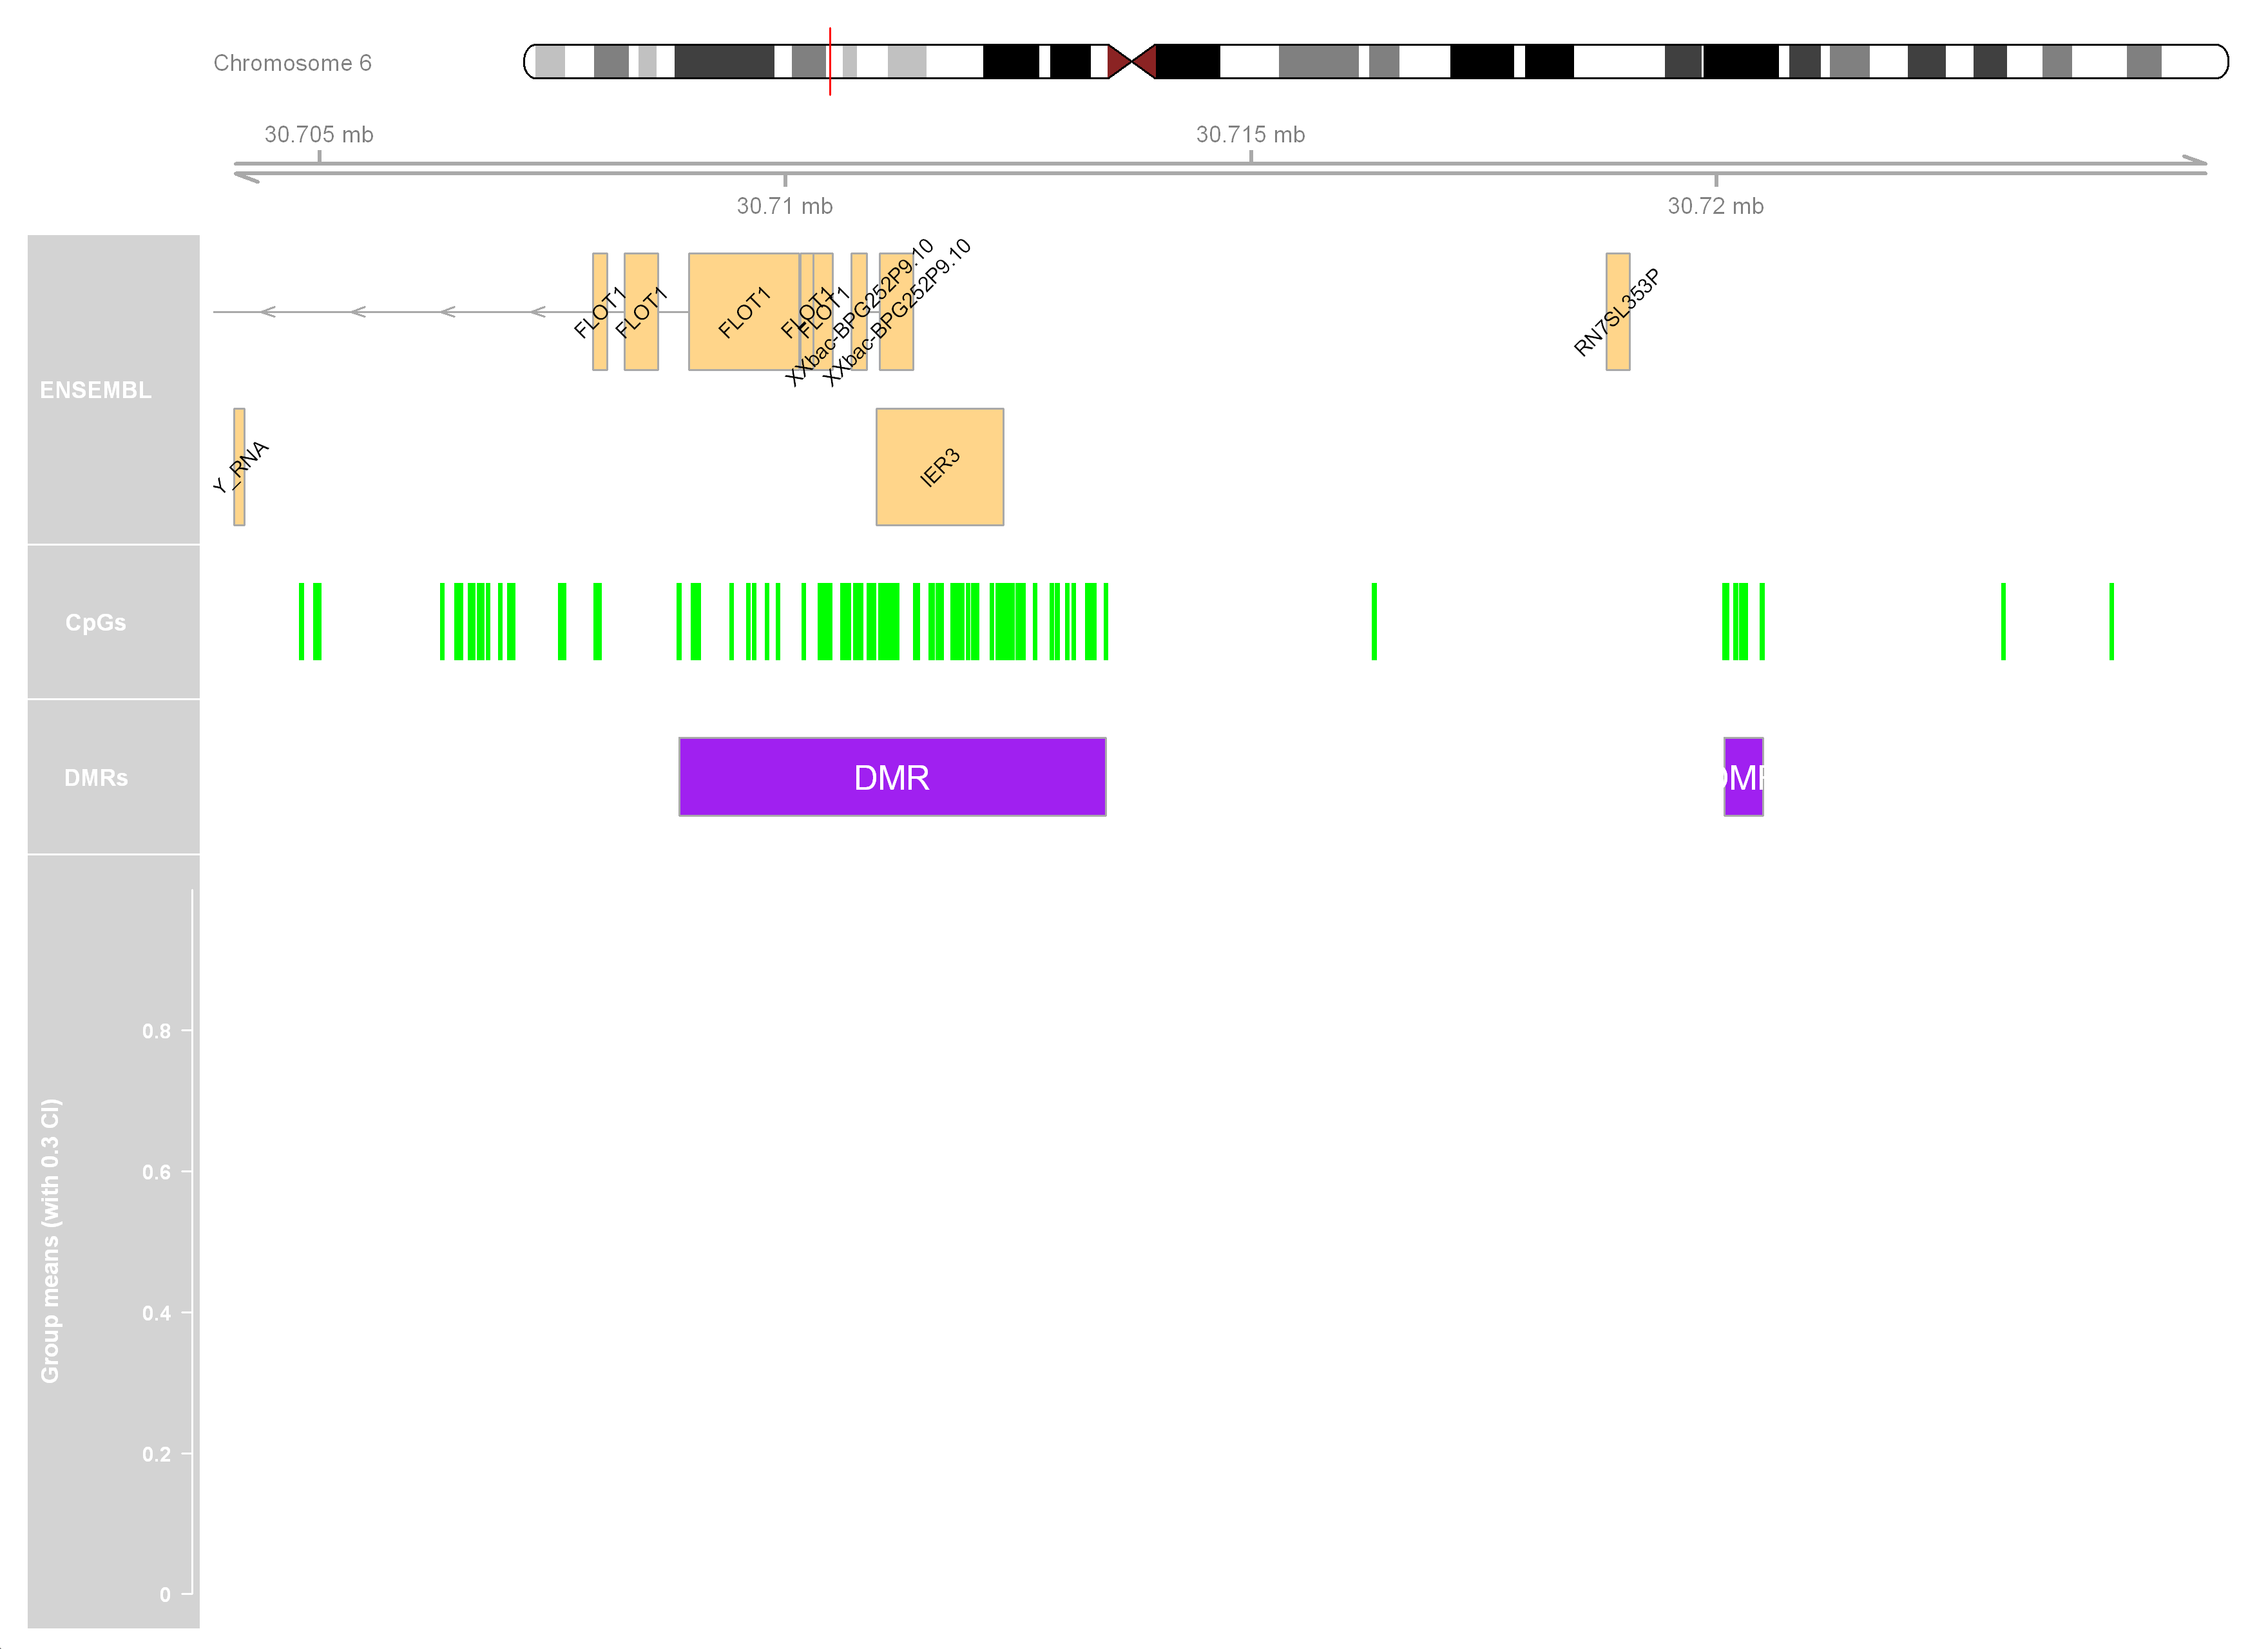

In [ ]:
ann <- cpg.annotate(
  object = m_sub,
  datatype = "array",
  what = "M",
  analysis.type = "differential",
  design = design,
  coef = 2,            # Sample_Grouptumor
  arraytype = "450K"
)

dmrc <- dmrcate(ann, lambda = 1000, C = 2)
dmrs <- extractRanges(dmrc, genome = "hg19")

dmrs[1:5]

DMR.plot(
  ranges = dmrs,
  dmr = 1,
  CpGs = beta_sub,
  phen.col = pheno$Sample_Group,
  arraytype = "450K",
  genome = "hg19"
) 

## 8) Gene set enrichment (GO / KEGG) with missMethyl

Gene set testing for methylation arrays is tricky because genes have different numbers of probes on the array.  
`gometh()` adjusts for this probe-number bias (and multi-gene mapping), which makes enrichment results more trustworthy.


All input CpGs are used for testing.



,ONTOLOGY,TERM,N,DE,P.DE,FDR
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GO:0071944,CC,cell periphery,5984,3546,5.002878e-28,1.104886e-23
GO:0005886,CC,plasma membrane,5531,3271,3.053116e-25,3.371403e-21
GO:0009653,BP,anatomical structure morphogenesis,2826,1810,4.060178e-18,2.988968e-14
GO:0048731,BP,system development,4182,2593,1.517831e-17,8.380326e-14
GO:0007275,BP,multicellular organism development,4849,2960,3.492943e-17,1.542833e-13
GO:0007155,BP,cell adhesion,1550,1018,5.963268e-17,2.194980e-13
GO:0030054,CC,cell junction,2410,1574,1.505660e-16,4.750358e-13
GO:0032501,BP,multicellular organismal process,7529,4301,3.701895e-16,1.021954e-12
GO:0007399,BP,nervous system development,2650,1714,7.965890e-16,1.954741e-12


All input CpGs are used for testing.



,Description,N,DE,P.DE,FDR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
hsa05412,Arrhythmogenic right ventricular cardiomyopathy,86,73,7.194047e-07,0.0002654603
hsa05414,Dilated cardiomyopathy,104,84,1.731065e-06,0.0003193814
hsa04517,IgSF CAM signaling,294,210,8.606761e-06,0.0007936967
hsa04820,Cytoskeleton in muscle cells,233,165,1.041261e-05,0.0007936967
hsa04518,Integrin signaling,153,116,1.075470e-05,0.0007936967
hsa04514,Cell adhesion molecule (CAM) interaction,153,112,4.444838e-05,0.0027335753
hsa05410,Hypertrophic cardiomyopathy,99,76,7.699203e-05,0.0033006664
hsa04382,Cornified envelope formation,207,127,8.557899e-05,0.0033006664
hsa04510,Focal adhesion,201,145,8.903031e-05,0.0033006664


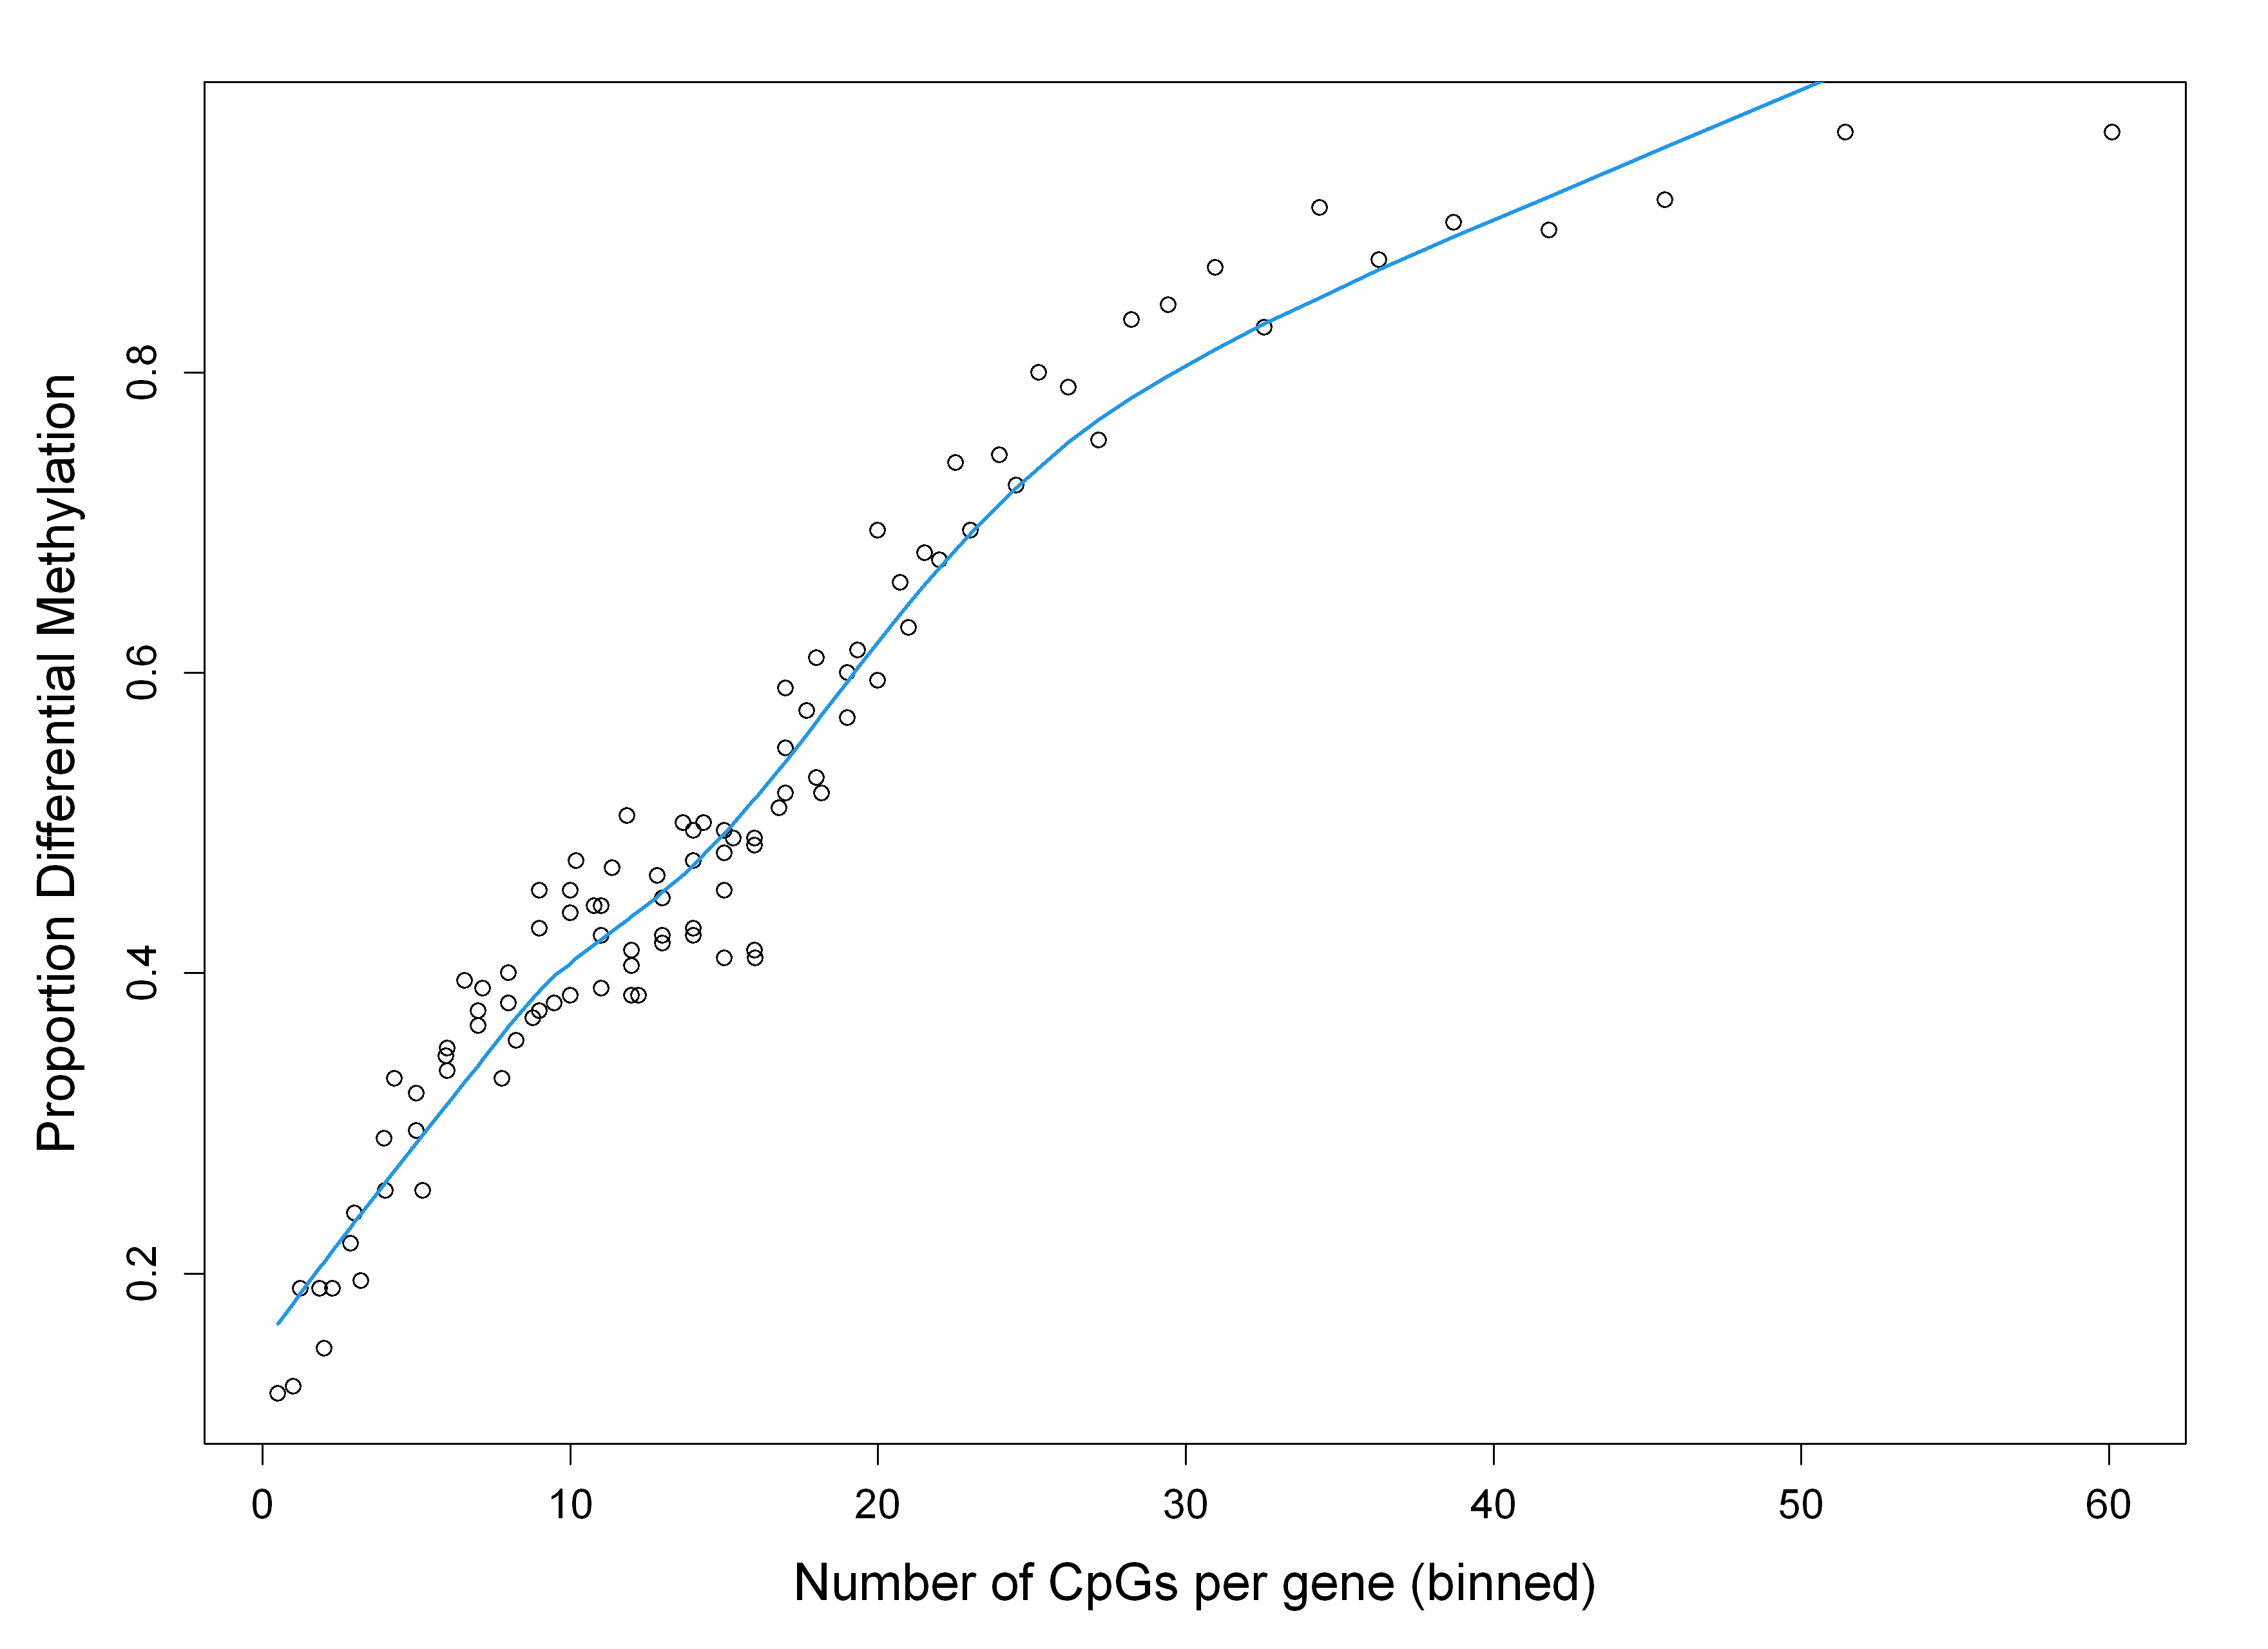

In [13]:
all_cpg <- rownames(m_sub)
sig_cpg <- rownames(dmp)[dmp$adj.P.Val < 0.05]

go <- gometh(sig.cpg = sig_cpg, all.cpg = all_cpg, collection = "GO",
             plot.bias = TRUE, array.type = "450K")
topGSA(go, number = 10)

kegg <- gometh(sig.cpg = sig_cpg, all.cpg = all_cpg, collection = "KEGG",
               array.type = "450K")
topGSA(kegg, number = 10)

## Additional considerations

- **Probe filtering**: in production you’ll usually remove cross-reactive probes, probes with common SNPs at the CpG or single-base extension, and (depending on your design) sex chromosome probes.
- **Normalization choice**: Noob is a good default; functional normalization (`preprocessFunnorm`) can be better when strong technical variation is present, especially in blood datasets with diverse cell mixes.
- **Batch effects**: if you have slide/plate/run information, include it in the design matrix (or use `duplicateCorrelation` / mixed models).
- **Cell composition**: for whole blood or tissues, estimate and adjust cell proportions (e.g., `estimateCellCounts`)—but for sorted cells like this dataset it’s less relevant.


## Typical follow-ups

- Plot methylation across *specific loci* of interest (e.g., FOXP3 enhancers) and link to expression if available.
- Integrate with RNA-seq (if available) to connect methylation changes to expression changes.
- Integrate with ATAC-seq/ChIP-seq to interpret DMRs in regulatory context.
